# Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.


<a id="Libraries"></a>
##  Загрузка библиотек

In [2]:
import random
import numpy as np
import statsmodels.stats as sm
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Подготовка данных

In [3]:
data = pd.read_excel('/home/результаты А_B.xlsx')

data.head(20)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


userid: id игрока

version: версия игры (gate_30 - контрольная, gate_40 - тестовая).

sumgamerounds: кол-во раундов сыгранных игроком

retention_1: Вернулся ли игрок в игру через 1 день после установки.

retention_7: Вернулся ли игрок в игру через 7 дней после установки.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Мы имеем данные от 90 189 игроков, которые установили игру, пока работал AB-тест.

In [ ]:
data.shape

(90189, 5)

Получили размерность датасета

In [ ]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


В столбце sum_gamerounds максимальное значение очень высокое среди остальных, проверим выброс ли это

In [ ]:
data.nlargest(5, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1
46344,5133952,gate_30,2251,1,1


Сравнивая с другими максимальными значениями, можно сделать вывод, что это выброс, поэтому, удалим его.

In [ ]:
data = data[data.sum_gamerounds < 3000]
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018800e+04,90188.000000,90188.000000,90188.000000
mean,4.998397e+06,51.320253,0.445214,0.186056
std,2.883298e+06,102.682719,0.496992,0.389154
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512211e+06,5.000000,0.000000,0.000000
50%,4.995804e+06,16.000000,0.000000,0.000000
75%,7.496461e+06,51.000000,1.000000,0.000000
max,9.999861e+06,2961.000000,1.000000,1.000000


Количество человек в группах существенно отличается.

In [ ]:
data.isna().sum()

,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


Пропущенных данных нет.

Проверим наши данные на корректность: каждый пользователь встрчается у нас только один раз?

In [ ]:
data.groupby('userid', as_index=False).agg({'version': pd.Series.nunique}).query('version > 1')

,userid,version


In [ ]:
data.shape[0] - data.userid.nunique()

0

Следовательно, данные корректны.

# Проверка на нормальность

H0: Данные распределены нормально. H1: Данные распределены ненормально.

Воспользуемся тестом Колмогорова-Смирнова, так как выборка больше 5000 и тест Шапиро-Уилка не даст точных результатов

In [4]:
# контрольная группа
control = data[data.version == 'gate_30'].sum_gamerounds
test_stat, pvalue = st.kstest(control, 'norm')
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.8724, p-value = 0.0000


In [6]:
# тестовая группа
test = data[data.version == 'gate_40'].sum_gamerounds
test_stat, pvalue = st.kstest(test, 'norm')
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.8707, p-value = 0.0000


**Вывод:** для обеих групп p-value<0.05, значит распределение в обеих группах не наормальное

# Проверка на однородность дисперсии:

In [ ]:
test_stat, pvalue = st.levene(control,test)
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.0751, p-value = 0.7840


Вывод: так как p-value >0.05, то дисперсия однородна.

**Применение гипотез:**

Согласно «Нормальному распределению» и «Предположению об однородности дисперсии» показано, что первый контроль НЕ принимает нулевую гипотезу, а второй принимает её. Это означает, что мы должны использовать команду mannwtihneyu() для применения гипотезы.

Критерий Манна-Уитни основан на сравнении каждого наблюдения xi в первой выборке с каждым наблюдением yj в другой выборке. Общее количество попарных сравнений, которые можно сделать, равно nxny.1

In [7]:
test_stat, pvalue = st.mannwhitneyu(control,test)
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1024331250.5000, p-value = 0.0502


Вывод:

Так как p-value примерно равно 0.05, то этого теста не будет достаточно для принятия решения о разнице в выборках

# Рассчитаем количество активных пользователей-игроков

Text(0.5, 1.0, 'Число раундов, которые сыграли пользователи в течении недели')

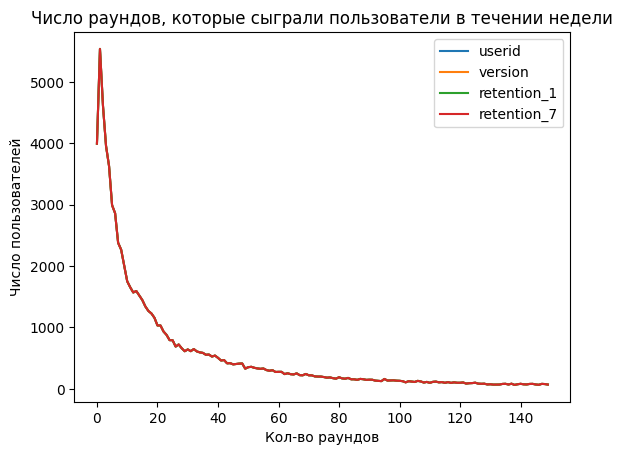

In [12]:
plot_data = data.groupby('sum_gamerounds').count()

ax = plot_data[:150].plot()
ax.set_xlabel('Кол-во раундов')
ax.set_ylabel('Число пользователей')
ax.set_title('Число раундов, которые сыграли пользователи в течении недели')

График показывает, что большенство пользователей играет менее 20 раундов. в неделю

Расссмотрим **активность пользователей в игре в течении недели**.

Для этого немного изменим распределение в группах.

In [13]:
A = data[data.version == 'gate_30']
print(A.head())
B = data[data.version == 'gate_40']
print(B.head())

plt.style.use('ggplot')
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(A.groupby(pd.cut(A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(B.groupby(pd.cut(B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3            0            0
1      337  gate_30              38            1            0
6     1066  gate_30               0            0            0
11    2101  gate_30               0            0            0
13    2179  gate_30              39            1            0
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165            1            0
3     483  gate_40               1            0            0
4     488  gate_40             179            1            1
5     540  gate_40             187            1            1
7    1444  gate_40               2            0            0


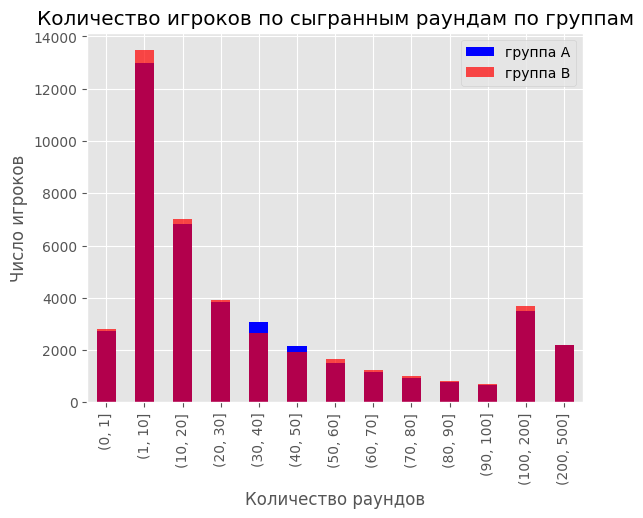

In [14]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Количество игроков по сыгранным раундам по группам')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Количество раундов')
ax.set_ylabel('Число игроков')
plt.legend(['группа A', 'группа B'])

График показывает, что между версиями нет большой разници. Есть небольшие различия в пределах 50 раундов

# Рассмотрим удержание пользователей в течении 1 дня

In [15]:
oneday = data.retention_1.groupby(data.version).sum()/data.retention_1.groupby(data.version).count()
print(oneday*100)

version
gate_30    44.818792
gate_40    44.228275
Name: retention_1, dtype: float64


**Обе версии имеют практически одинаковые результаты.**

# Рассмотрим удержание пользователей в течении недели

In [16]:
oneweek = data.retention_7.groupby(data.version).sum()/data.retention_7.groupby(data.version).count()
print(oneweek*100)

version
gate_30    19.020134
gate_40    18.200004
Name: retention_7, dtype: float64


**У контрольной версии удержание игроков в течении недели выше**

**Вывод:** По статистическим показателям разницы между контрольной и тестовой версии игры нет. По количеству сыгранных раундов обе версии показали примерно одинаковые результаты, следовательно, изменение версии не влияет на активность в игре. Тестовая версия показала себя хуже в удержании игроков в течении недели, следовательно, в целях удержания аудитории стоит оставить контрольную версию игры.